# Import Data

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.io
import scipy.signal as signal
from scipy.signal import find_peaks

import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.utils import to_categorical

from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
import pywt
import time

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, LSTM, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,CSVLogger

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, Activation
# from keras.callbacks import EarlyStopping

# plt.style.use('ggplot')
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline  

c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\ten

ModuleNotFoundError: No module named 'mlxtend'

In [0]:
# set data folder path
# DATA_FOLDER = 'D:\\NUS\\semester 2\\Course 3\\CA\\MAREA_dataset'
# DATA_FOLDER = '/Users/jiahao/Downloads/MAREA_dataset'
DATA_FOLDER = r'D:/NUS_TERM2_CA3/MAREA_dataset'
# DATA_FOLDER = 'C:/Users/david/Documents/CA3/MAREA_dataset-201/MAREA_dataset'
ACTIVITY_FOLDER = os.path.join(DATA_FOLDER, 'Activity Timings')
SUBJECT_FOLDER = os.path.join(DATA_FOLDER, 'Subject Data_txt format')
PROCESSED_FOLDER = os.path.join(DATA_FOLDER, 'Processed_data')

# define activity timing labels
label_indoor = ['tread_flat_walk_start',
                'tread_flat_walk_end',
                'tread_flat_run_end',
                'tread_slope_walk_start',
                'tread_slope_walk_end',
                'indoor_flat_walk_start',
                'indoor_flat_walk_end',
                'indoor_flat_run_end']

label_outdoor = ['outdoor_walk_start',
                 'outdoor_walk_end',
                 'outdoor_run_end']

# prepare timing index for different activities
df_indoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Indoor Experiment Timings.txt')
                             , names=label_indoor)

df_outdoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Outdoor Experiment Timings.txt')
                              , names=label_outdoor)

df_indoor_time["subject"] = ["Sub" + str(i) for i in range(1, 12)]
df_outdoor_time["subject"] = ["Sub" + str(j) for j in range(12, 21)]

In [0]:
  # set up activity column names
axis_list = ['accX', 'accY', 'accZ']
pos_list = ['LF', 'RF', 'Waist', 'Wrist']
sub_list = ['Sub' + str(i) for i in range(1, 21)]
column_names = [f"{y}_{x}" for x,y in itertools.product(pos_list, axis_list)]

# TODO: purposely exclude subject 4 first as missing data -- dont know how to deal with missing data for signal
sub_list.remove('Sub4')

In [4]:
column_names

['accX_LF',
 'accY_LF',
 'accZ_LF',
 'accX_RF',
 'accY_RF',
 'accZ_RF',
 'accX_Waist',
 'accY_Waist',
 'accZ_Waist',
 'accX_Wrist',
 'accY_Wrist',
 'accZ_Wrist']

In [0]:
# create master dataframe
df = pd.DataFrame()
for sub in sub_list:
    df_lf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'LF.txt'))
    df_rf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'RF.txt'))
    df_waist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Waist.txt'))
    df_wrist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Wrist.txt'))
    df_sub = pd.concat([df_lf, df_rf, df_waist, df_wrist], axis=1)
    df_sub.columns = column_names

    df_sub = df_sub.copy()
    n = int(sub[3:])
    if n > 11:
        sub_row = df_outdoor_time[df_outdoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['outdoor_walk_end'], 'label'] = 'outdoor_walk'
        df_sub.loc[tmp['outdoor_walk_end']: tmp['outdoor_run_end'], 'label'] = 'outdoor_run'
    else:
        sub_row = df_indoor_time[df_indoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['tread_flat_walk_end'], 'label'] = 'tread_flat_walk'
        df_sub.loc[tmp['tread_flat_walk_end']: tmp['tread_flat_run_end'],'label'] = 'tread_flat_run'
        df_sub.loc[tmp['tread_flat_run_end']: tmp['tread_slope_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['tread_slope_walk_start']: tmp['tread_slope_walk_end'],'label'] = 'tread_slope_walk'
        df_sub.loc[tmp['tread_slope_walk_end']: tmp['indoor_flat_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['indoor_flat_walk_start']: tmp['indoor_flat_walk_end'],'label'] = 'indoor_flat_walk'
        df_sub.loc[tmp['indoor_flat_walk_end']: tmp['indoor_flat_run_end'],'label'] = 'indoor_flat_run'

    df_sub['subject'] = sub
    df = df.append(df_sub)
    # print(df.shape)

In [6]:
df.head(5)

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,accY_Wrist,accZ_Wrist,label,subject
0,-2.196,-11.765,-1.569,4.078,-6.902,2.196,-0.157,-8.157,0.784,0.941,-11.451,-2.510,tread_flat_walk,Sub1
1,-2.510,-10.353,-2.039,4.392,-8.000,1.255,-0.157,-8.000,1.255,0.627,-10.510,-2.353,tread_flat_walk,Sub1
2,-2.353,-10.824,-2.510,4.863,-8.314,0.941,-0.157,-7.843,1.255,0.784,-10.196,-2.039,tread_flat_walk,Sub1
3,-1.882,-10.667,-2.667,4.549,-9.412,-0.157,-0.157,-8.000,1.412,1.255,-10.039,-1.412,tread_flat_walk,Sub1
4,-1.412,-10.353,-2.824,3.451,-10.353,-0.784,-0.627,-7.529,1.882,1.569,-10.196,-1.255,tread_flat_walk,Sub1


# Preprocess Data

## Function: Signal Processing (Split & Transformation)

In [0]:
def PreprocessingSignal(df, label, subject, feature, window, 
                        wavelet_args = {"type":"Y",
                                        "threshold":2, 
                                        "wavedec_options":{"wavelet":"db4", "level":2},
                                        "waverec_options":{"wavelet":"db4"}},
                        window_args = {"type":"no_overlap"}
                       ):
    
    df = df.loc[(df['label'] == label) & (df['subject'] == subject)]
    
    ### Do wavelet transform or NOT ###
    if wavelet_args["type"] == "Y":
        # wavelet_args = {"threshold":2, "options":{"wavelet":"db4", "level":0.8}}
        # Do wavelet transform
        signal_orig = df[feature].values
        args1 = wavelet_args["wavedec_options"]
        coeffs_orig = pywt.wavedec(signal_orig, **args1)
        coeffs_filter = coeffs_orig.copy()
        threshold = wavelet_args["threshold"]
        for i in range(1, len(coeffs_orig)):
            coeffs_filter[i] = pywt.threshold(coeffs_orig[i], threshold*max(coeffs_orig[i]))
        args2 = wavelet_args["waverec_options"]
        signal_denoised = pywt.waverec(coeffs_filter, **args2) 
        to_process_df = pd.DataFrame(signal_denoised)
    else:
        tmp_df = df[feature].reset_index()
        to_process_df = tmp_df.drop(columns=["index"])
        to_process_df.columns = [0]
    ### Do wavelet transform or NOT ###
        
    min_index = min(to_process_df.index)
    max_index = max(to_process_df.index)
    
    ### Define Method to cut signal into windows ###
    if window_args["type"] == "no_overlap":
        # window_args = {"type":"no_overlap"}
        index_list = range(min_index, max_index+1, int(window))
    elif window_args["type"] == "with_overlap":
        # window_args = {"type":"with_overlap", "overlap_perc":0.5}
        overlap_perc = window_args["overlap_perc"]
        step = int(window/(1/overlap_perc))
        index_list = range(min_index, max_index+1, step)
    elif window_args["type"] == "by_peaks":
        index_list = window_args["peaks_index"]
    ### Define Method to cut signal into windows ###
    
    ### Cut signal into windows ###
    windowed_selected_chunk_array = []
    for index in index_list:
        windowed_selected_chunk = to_process_df[0].iloc[index:index+window] 
        if windowed_selected_chunk.shape[0] == window:
            windowed_selected_chunk_array.append(windowed_selected_chunk.values)
    output_np_arr = np.array(windowed_selected_chunk_array)
    ### Cut signal into windows ###
    
    output_np_label = np.asarray([label]*output_np_arr.shape[0])
    
    return output_np_arr, output_np_label


## Label Setup

In [0]:
#feature_list = column_names TODO: is this line still needed?

# Create
indoor_activity = ['rest',
                   'tread_flat_walk',
                    'tread_flat_run',
                    'tread_slope_walk',
                    'indoor_flat_walk',
                    'indoor_flat_run'
                    ]
outdoor_activity = ['outdoor_walk', 'outdoor_run']

indoor_sub = ['Sub' + str(i) for i in range(1, 12)]
outdoor_sub = ['Sub' + str(i) for i in range(12, 21)]
indoor_sub.remove('Sub4')

In [9]:
# indoor_sub

['Sub1',
 'Sub2',
 'Sub3',
 'Sub5',
 'Sub6',
 'Sub7',
 'Sub8',
 'Sub9',
 'Sub10',
 'Sub11']

## Function: Train & Test Split (including Signal Processing)

In [0]:
def PrepareFeature(df, feature, split_method, window,
                   indoor_activity, outdoor_activity, indoor_sub, outdoor_sub, 
                   wavelet_args, window_args, train_size=0.8):
    
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()

    # train_size = 0.8
    #window = 128*4
    #indoor_activity = ['tread_slope_walk', 'tread_flat_walk', 'indoor_flat_run', 'indoor_flat_walk', 'tread_flat_run', 'rest']
    #outdoor_activity = ['outdoor_walk', 'outdoor_run']
    #indoor_sub = ['Sub1', 'Sub2', 'Sub3', 'Sub5', 'Sub6', 'Sub7', 'Sub8', 'Sub9', 'Sub10', 'Sub11',]
    #outdoor_sub = ['Sub12', 'Sub13', 'Sub14', 'Sub15', 'Sub16', 'Sub17', 'Sub18', 'Sub19', 'Sub20']
    # (SAMPLE) wavelet args options #
    #wavelet_args = {"type":"Y", "threshold":2, "wavedec_options":{"wavelet":"db4", "level":2}, "waverec_options":{"wavelet":"db4"}}
    #wavelet_args = {"type":"N"}
    # (SAMPLE) window args options #
    #window_args = {"type":"by_peaks", "find_peaks_col":"accX_LF", "find_peaks_options": {"prominence":30, "height":20}} # "peaks_index":peaks_index_list will be added
    #window_args = {"type":"with_overlap", "overlap_perc":0.5} 
    #window_args = {"type":"no_overlap"}

    #TODO: find_peaks from a given column
    #NOTE: code will break when using -> window_args = {"type":"by_peaks", "peaks_index":peaks_index_list}
    
    # method 1: split within each subject
    if split_method == 'TrainTestSplitWithinSubject':
        for feature in [feature]:
            #indoor activity
            for sub in indoor_sub:
                for activity in indoor_activity:
                    if window_args["type"] == "by_peaks":
                        data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                        args = window_args["find_peaks_options"]
                        peak_col = window_args["find_peaks_col"]
                        peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                        window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    
                    train_len = int(train_size*len(output_np_arr))
                    tr_x = output_np_arr[:train_len,:]
                    ts_x = output_np_arr[train_len:len(output_np_arr),:]
                    
                    test_len = int(train_size*len(output_label))
                    tr_y = output_label[:test_len]
                    ts_y = output_label[test_len:len(output_label)]
                
                    X_train = X_train.append(pd.DataFrame(tr_x))
                    X_test = X_test.append(pd.DataFrame(ts_x))
                    y_train = y_train.append(pd.DataFrame(tr_y))
                    y_test = y_test.append(pd.DataFrame(ts_y)) 

            #outdoor activity
            for sub in outdoor_sub:
                for activity in outdoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    
                    train_len = int(train_size*len(output_np_arr))
                    tr_x = output_np_arr[:train_len,:]
                    ts_x = output_np_arr[train_len:len(output_np_arr),:]
                    
                    test_len = int(train_size*len(output_label))
                    tr_y = output_label[:test_len]
                    ts_y = output_label[test_len:len(output_label)]
                
                    X_train = X_train.append(pd.DataFrame(tr_x))
                    X_test = X_test.append(pd.DataFrame(ts_x))
                    y_train = y_train.append(pd.DataFrame(tr_y))
                    y_test = y_test.append(pd.DataFrame(ts_y))
    
    # method 2: split all samples randomly
    if split_method == 'Random':
        for feature in [feature]:
#             output = np.asarray(list())
#             label = np.asarray(list())
            output = np.empty((0,window), float)
            label = np.empty((0,), float)
            
            #indoor activity
            for sub in indoor_sub:
                for activity in indoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    output = np.append(output, output_np_arr, axis = 0)
                    label = np.append(label, output_label, axis = 0)
                    
            #outdoor activity:
            for sub in outdoor_sub:
                for activity in outdoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    output = np.append(output, output_np_arr, axis = 0)
                    label = np.append(label, output_label, axis = 0)
                    
            train_len = int(train_size*len(output))
            tr_x = output[:train_len,:]
            ts_x = output[train_len:len(output),:]
                    
            test_len = int(train_size*len(label))
            tr_y = label[:test_len]
            ts_y = label[test_len:len(label)]
                
            X_train = X_train.append(pd.DataFrame(tr_x))
            X_test = X_test.append(pd.DataFrame(ts_x))
            y_train = y_train.append(pd.DataFrame(tr_y))
            y_test = y_test.append(pd.DataFrame(ts_y))
    
    # method 3: only keep several subjects in the train, 
    #           put other subjects in the test
    if split_method == 'DifferentSubjectsInTrainTest':
        for feature in [feature]:  
            train_sub = np.empty((0,window), float)
            train_label_sub = np.empty((0,), float)
            test_sub = np.empty((0,window), float)
            test_label_sub = np.empty((0,), float)
            
            #indoor activity
            indoor_sub_train_len = int(train_size*len(indoor_sub))
            indoor_sub_train = indoor_sub[:indoor_sub_train_len]
            indoor_sub_test = indoor_sub[indoor_sub_train_len:len(indoor_sub)]
            
            for sub in indoor_sub_train:
                for activity in indoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          #print("THIS", activity, peaks_index_list)
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    train_sub = np.append(train_sub, output_np_arr, axis = 0)
                    train_label_sub = np.append(train_label_sub, output_label, axis = 0)
            
            for sub in indoor_sub_test:
                for activity in indoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    test_sub = np.append(test_sub, output_np_arr, axis = 0)
                    test_label_sub = np.append(test_label_sub, output_label, axis = 0)
            
                    
            #outdoor activity
            outdoor_sub_train_len = int(train_size*len(outdoor_sub))
            outdoor_sub_train = outdoor_sub[:outdoor_sub_train_len]
            outdoor_sub_test = outdoor_sub[outdoor_sub_train_len:len(outdoor_sub)]
            
            for sub in outdoor_sub_train:
                for activity in outdoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    train_sub = np.append(train_sub, output_np_arr, axis = 0)
                    train_label_sub = np.append(train_label_sub, output_label, axis = 0)
            
            for sub in outdoor_sub_test:
                for activity in outdoor_activity:
                    if window_args["type"] == "by_peaks":
                          data_df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
                          args = window_args["find_peaks_options"]
                          peak_col = window_args["find_peaks_col"]
                          peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
                          window_args["peaks_index"] = peaks_index_list
                    output_np_arr, output_label = PreprocessingSignal(df, activity, sub, feature, window, wavelet_args, window_args)
                    test_sub = np.append(test_sub, output_np_arr, axis = 0)
                    test_label_sub = np.append(test_label_sub, output_label, axis = 0)
                    
            X_train = pd.DataFrame(train_sub)
            y_train = pd.DataFrame(train_label_sub)
            X_test = pd.DataFrame(test_sub)
            y_test = pd.DataFrame(test_label_sub)
        
    return X_train, X_test, y_train, y_test

In [0]:
# activity = 'tread_slope_walk'
# sub = 'Sub1'

# window_args = {"type":"by_peaks", "find_peaks_col":"accX_LF", "find_peaks_options": {"prominence":30, "height":20}}

# data_df = df = df.loc[(df['label'] == activity) & (df['subject'] == sub)]
# args = window_args["find_peaks_options"]
# peak_col = window_args["find_peaks_col"]
# peaks_index_list = list(find_peaks(data_df[peak_col], **args)[0])
# window_args["peaks_index"] = peaks_index_list

## Test

In [0]:
# TODO: is this for testing? David: Yes
window = 128*4

# for selection, shoud be commented out
# indoor_activity = ['rest',
#                    'tread_flat_walk',
#                     'tread_flat_run',
#                     'tread_slope_walk',
#                     'indoor_flat_walk',
#                     'indoor_flat_run',
#                    ]
# outdoor_activity = ['outdoor_walk', 'outdoor_run']
# indoor_sub = ['Sub1', 'Sub2', 'Sub3', 'Sub5', 'Sub6', 'Sub7', 'Sub8', 'Sub9', 'Sub10', 'Sub11',]
# outdoor_sub = ['Sub12', 'Sub13', 'Sub14', 'Sub15', 'Sub16', 'Sub17', 'Sub18', 'Sub19', 'Sub20']


split_method = "TrainTestSplitWithinSubject"
# split_method = "Random"
# split_method = "DifferentSubjectsInTrainTest"

# wavelet_args = {"type":"Y", "threshold":2, "wavedec_options":{"wavelet":"db4", "level":2}, "waverec_options":{"wavelet":"db4"}}
wavelet_args = {"type":"N"}
window_args = {"type":"by_peaks", "find_peaks_col":"accX_LF", "find_peaks_options": {"prominence":30, "height":20}}
#window_args = {"type":"with_overlap", "overlap_perc":0.5} 
# window_args = {"type":"no_overlap"}

In [13]:
# SAMPLE #

feature = 'accY_LF'
# feature_list = column_names
# for feature in column_names:
    # (example) feature = accX_LF (which is stored in the column_names)
    
X_train, X_test, y_train, y_test = PrepareFeature(df, feature, split_method, window,
                                                  indoor_activity, outdoor_activity, indoor_sub, outdoor_sub,
                                                  wavelet_args, window_args)


X_train_filename = "_".join(['X_train', feature, "Window"+str(window), "Wavelet" + wavelet_args["type"], window_args["type"], split_method]) + '.txt'
X_test_filename = "_".join(['X_test', feature, "Window"+str(window), "Wavelet" + wavelet_args["type"], window_args["type"], split_method]) + '.txt'
y_train_filename = "_".join(['y_train', feature, "Window"+str(window), "Wavelet" + wavelet_args["type"], window_args["type"], split_method]) + '.txt'
y_test_filename = "_".join(['y_test', feature, "Window"+str(window), "Wavelet" + wavelet_args["type"], window_args["type"], split_method]) + '.txt'

X_train.to_csv(X_train_filename, header=None, index=False, sep='\t')
X_test.to_csv(X_test_filename, header=None, index=False, sep='\t')

pd.DataFrame(y_train).to_csv(y_train_filename, header=None, index=False, sep='\t')
pd.DataFrame(y_test).to_csv(y_test_filename, header=None, index=False, sep='\t')

print("Saved X_train to %s" %(X_train_filename))
print("Saved X_test to %s" %(X_test_filename))
print("Saved X_train to %s" %(y_train_filename))
print("Saved X_test to %s" %(y_test_filename))

Saved X_train to X_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt
Saved X_test to X_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt
Saved X_train to y_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt
Saved X_test to y_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt


In [0]:
## TODO THIS PART

In [0]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [0]:
def load_group(filenames):
    loaded = list()
    for name in filenames:
        data = load_file(name)
        loaded.append(data)
    
    loaded = np.dstack(loaded)
    return loaded

In [0]:
def load_dataset_group(group):
    if group == 'train':
              # X_filenames = ['train_accX_LF.txt','train_accY_LF.txt','train_accZ_LF.txt',
        #                     'train_accX_RF.txt','train_accY_RF.txt','train_accZ_RF.txt',
        #                     'train_accX_Waist.txt','train_accY_Waist.txt','train_accZ_Waist.txt',
        #                     'train_accX_Wrist.txt','train_accY_Wrist.txt','train_accZ_Wrist.txt']

        X_filenames = ['X_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt']
        y_filename = 'y_train_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt'
        X = load_group(X_filenames)
        y = load_file(y_filename)
    else:
              # X_filenames = ['test_accX_LF.txt','test_accY_LF.txt','test_accZ_LF.txt',
        #                     'test_accX_RF.txt','test_accY_RF.txt','test_accZ_RF.txt',
        #                     'test_accX_Waist.txt','test_accY_Waist.txt','test_accZ_Waist.txt',
        #                     'test_accX_Wrist.txt','test_accY_Wrist.txt','test_accZ_Wrist.txt']

        X_filenames = ['X_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt']
        y_filename = 'y_test_accY_LF_Window512_WaveletN_by_peaks_TrainTestSplitWithinSubject.txt'
        X = load_group(X_filenames)
        y = load_file(y_filename)
    return X,y

In [0]:
def load_dataset():
    X_train, y_train = load_dataset_group('train') #load_group(X_filenames), load_file(y_filename) 
    X_test, y_test = load_dataset_group('test')
    return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = load_dataset()

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.shape[1])
print(X_train.shape[2])
print(y_train.shape[1])

(16068, 512, 1)
(16068, 1)
(4059, 512, 1)
(4059, 1)
512
1
1


In [0]:
# activity mapping dictionary
activity_to_num_mapping = {
    "rest":0,
    # indoor
    "tread_flat_walk":1,
    "tread_flat_run":2,
    "tread_slope_walk":3,
    "indoor_flat_walk":4,
    "indoor_flat_run":5,
    # outdoor
    "outdoor_walk":6,
    "outdoor_run":7
    }

# mapping the activity
y_train = np.vectorize(activity_to_num_mapping.get)(y_train)
y_test = np.vectorize(activity_to_num_mapping.get)(y_test)

# convert to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [22]:
# np.set_printoptions(edgeitems=5)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [23]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.shape[1])
print(X_train.shape[2])
print(y_train.shape[1])

(16068, 512, 1)
(16068, 8)
(4059, 512, 1)
(4059, 8)
512
1
8


# Modelling

## LSTM

In [57]:
# create LSTM Model
def createLSTMModel(n_timesteps=X_train.shape[1], n_features=X_train.shape[2], n_outputs=y_train.shape[1]):
    ipt = Input(shape=(n_timesteps, n_features))
    x = LSTM(100)(ipt)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(n_outputs, activation='softmax')(x)

    model = Model(inputs=ipt, outputs=x)

# Sequential API
    # model = Sequential()
    # model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.5))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = createLSTMModel(n_timesteps=X_train.shape[1], n_features=X_train.shape[2], n_outputs=y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 808       
Total params: 51,708
Trainable params: 51,708
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_name = 'v1'
filepath        = os.path.join(model_name + ".hdf5")
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(os.path.join(model_name +'.csv'))
callbacks_list  = [checkpoint,csv_logger]

In [60]:
verbose = 1
epochs = 5
batch_size = 128
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, 
                    verbose=verbose, callbacks=callbacks_list)

Train on 16068 samples, validate on 4059 samples
Epoch 1/5
16000/16068 [============================>.] - ETA: 0s - loss: 1.7002 - acc: 0.3264
Epoch 00001: val_acc improved from -inf to 0.34368, saving model to v1.hdf5
16068/16068 [==============================] - 112s 7ms/sample - loss: 1.6997 - acc: 0.3265 - val_loss: 1.5431 - val_acc: 0.3437
Epoch 2/5
16000/16068 [============================>.] - ETA: 0s - loss: 1.5169 - acc: 0.3724
Epoch 00002: val_acc improved from 0.34368 to 0.43360, saving model to v1.hdf5
16068/16068 [==============================] - 102s 6ms/sample - loss: 1.5171 - acc: 0.3725 - val_loss: 1.5793 - val_acc: 0.4336
Epoch 3/5
16000/16068 [============================>.] - ETA: 0s - loss: 1.4248 - acc: 0.3999
Epoch 00003: val_acc improved from 0.43360 to 0.47007, saving model to v1.hdf5
16068/16068 [==============================] - 102s 6ms/sample - loss: 1.4249 - acc: 0.4000 - val_loss: 1.4710 - val_acc: 0.4701
Epoch 4/5
16000/16068 [=========================

# Evalutaion

## Data Prediction

In [0]:
# prediction preparation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

## Model Accuracy

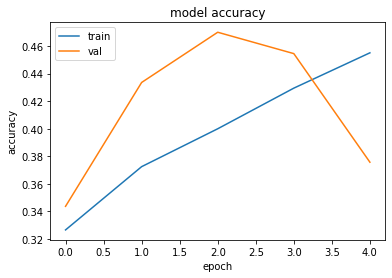

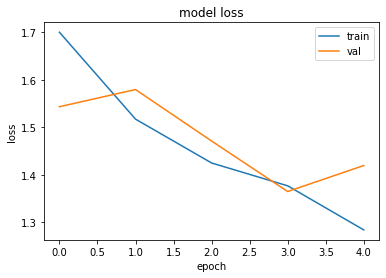

In [62]:
# plot model accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_name + '_model_acc', dpi=300)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(model_name + '_model_loss', dpi=300)
plt.show()

## Confusion Matrix

Best accuracy (on validation dataset): 37.57%
[[  0  39   1  95   0   0   1   0]
 [  0 427  76  28   0  32 408   0]
 [  0   9  61   0   0 134   1  75]
 [  0 537   0 557   0   0   3   0]
 [  0 181   0 135   0   0  38   0]
 [  0  68  30   5   0 114  13 194]
 [  0 279   3  36   0   2 131   2]
 [  0  21   9   3   0  73   3 235]]


<Figure size 432x288 with 0 Axes>

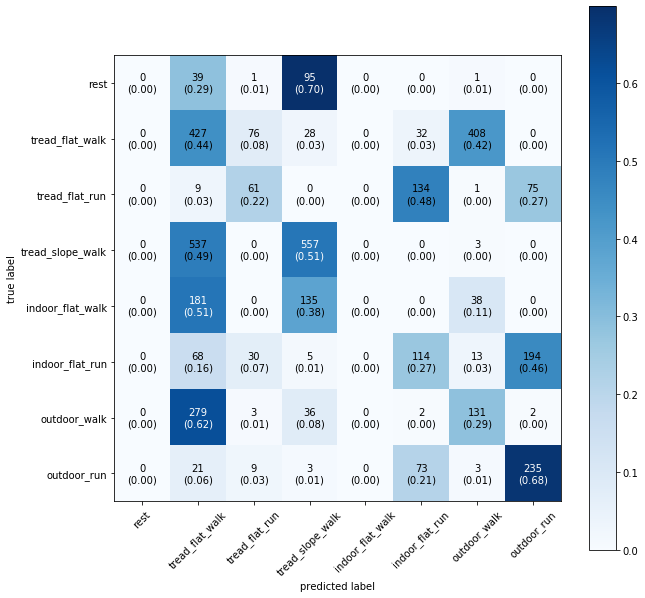

In [65]:
class_label = np.concatenate((indoor_activity, outdoor_activity))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Best accuracy (on validation dataset): %.2f%%" % (accuracy_score(y_test, y_pred) * 100))
print(cnf_matrix)

plt.figure()
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                class_names=class_label,
                                figsize=(10,10))
plt.savefig(model_name + '_confusion_matrix', dpi=300)
plt.show()

## Classification Report

In [64]:
# display report
report_display = classification_report(y_test, y_pred, target_names=class_label, digits=4)
print("Classification Report:")
print(report_display)

# create report and store in csv
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(model_name+'_classification_report')

Classification Report:
                  precision    recall  f1-score   support

            rest     0.0000    0.0000    0.0000       136
 tread_flat_walk     0.2735    0.4398    0.3373       971
  tread_flat_run     0.3389    0.2179    0.2652       280
tread_slope_walk     0.6484    0.5077    0.5695      1097
indoor_flat_walk     0.0000    0.0000    0.0000       354
 indoor_flat_run     0.3211    0.2689    0.2927       424
    outdoor_walk     0.2191    0.2892    0.2493       453
     outdoor_run     0.4644    0.6831    0.5529       344

        accuracy                         0.3757      4059
       macro avg     0.2832    0.3008    0.2834      4059
    weighted avg     0.3614    0.3757    0.3582      4059

